In [1]:
import re, pickle, time, os, itertools, copy
import plot_utils, train_utils, function_utils, dict_utils, build_feature_utils

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import r_regression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Remove and fix some data

In [2]:
batch1 = pickle.load(open(os.path.join('.','Data','batch1.pkl'), 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(os.path.join('.','Data','batch2.pkl'),'rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
## THIS IS MY CHANGE, 3/6/2021: b2c1 is an anomaly; 148 cycle life. REMOVE at cell above and below

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(os.path.join('.','Data','batch3.pkl'),'rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())

numBat = numBat1 + numBat2 + numBat3
bat_dict = {'LFP_data': {**batch1, **batch2, **batch3}}

In [3]:
# index used in the nature paper
# test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_ind = np.arange(0,(numBat1+numBat2),2)
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

# remove the anomalous cell, b2c1
test_ind = np.delete(test_ind, 21)
test_ind = np.append(test_ind, numBat1+numBat2-1)

In [4]:
# Seggregate the data into charge, discharge and their rests
bat_index_dict = dict_utils.create_bat_index_dict(bat_dict['LFP_data'].keys(), bat_dict['LFP_data'])
# And assign back into bat_dict for ease of use
bat_dict = function_utils.set_stepIndex(bat_dict, bat_index_dict)

# Check for error in the step index assignment
for cellNo in bat_dict['LFP_data'].keys():
    for cycleNo in list(bat_dict['LFP_data'][cellNo]['cycles'].keys())[1:202]:
        checkCell = bat_dict['LFP_data'][cellNo]['cycles'][cycleNo]
        idxCh = np.where(checkCell['Step_index'] == 3)[0]
        idxDis = np.where(checkCell['Step_index'] == 5)[0]

        if np.mean(checkCell['Qd'][idxCh][-10:]) > 0.1: print("The mean Qd for charging index is higher than 0.1 for", cellNo, cycleNo)
        if checkCell['Qd'][idxDis[0]] > 0.1: print("The starting Qd is higher than 0.1 for", cellNo, cycleNo)

# Manual fix for certain cell/cycle
fixCell = bat_dict['LFP_data']['b2c27']['cycles']
for keyName in fixCell['118'].keys():
    fixCell['118'][keyName] = fixCell['117'][keyName]

Rest index is empty for b1c45 270
The mean Qd for charging index is higher than 0.1 for b2c12 252
The starting Qd is higher than 0.03 for b2c12 252
The starting Qd is higher than 0.03 for b2c27 118
The starting Qd is higher than 0.03 for b2c44 247
Rest index is empty for b2c44 247
The starting Qd is higher than 0.1 for b2c27 118


#### Only consider CC-region only and interpolate

In [5]:
stepTotal = 100
testDict = copy.deepcopy(bat_dict)

for cellNo in testDict['LFP_data'].keys():
    for cycleNo in testDict['LFP_data'][cellNo]['cycles'].keys():
        if cycleNo == '0': continue
        testCellwCycle = testDict['LFP_data'][cellNo]['cycles'][cycleNo]
        
        idxDis = np.where(testCellwCycle['Step_index'] == 5)[0]
        idxCh = np.where(testCellwCycle['Step_index'] == 3)[0]
        
        linDictDis = function_utils.interpolate_data(xLimitList = [3.55, 2.05], step = stepTotal, cellDictOri = testCellwCycle, 
                                                 yKeyList = ['Qd', 'T_cell', 'V'], xKey = 'V', idxList = idxDis)
        for keyName in linDictDis.keys(): testCellwCycle[keyName] = linDictDis[keyName].copy()
        
        
        linDictCh = function_utils.interpolate_data(xLimitList = [0, 0.88], step = stepTotal, cellDictOri = testCellwCycle, 
                                                  yKeyList = ['Qc', 'T_cell'], xKey = 'Qc', idxList = idxCh)
        for keyName in linDictCh.keys(): testCellwCycle[keyName] = linDictCh[keyName].copy()

In [7]:
cycleList = [str(x) for x in np.arange(1,150,1)]
T_Q =  build_feature_utils.create_T_Q_lin_feature(testDict, cycleList)
dTdQ =  build_feature_utils.create_dTdQ_lin_feature(testDict, cycleList)

nature_dict = build_feature_utils.create_nature_feature_v2(bat_index_dict, testDict)
nature_dict_2to10 = build_feature_utils.create_nature_feature_v2_2to10(bat_index_dict, testDict)

TQKeynameUnique = function_utils.get_unique_keyname_tuple(T_Q)
dTdQKeynameUnique = function_utils.get_unique_keyname_tuple(dTdQ)
natureKeynameUnique = list(nature_dict.keys())[5:]
nature2to10KeynameUnique = list(nature_dict_2to10.keys())[5:]

In [8]:
# import re
chargepolicylst = []
cyclelifelst = []
avgchargepolicylst = []
diffchargepolicylst = []
avgchargetimelst = []

timeCycles = list(map(str, np.arange(1,11,1))) #first 10 cycles for average charge time

for batno in testDict['LFP_data'].keys():
    chargepolicylst.append((testDict['LFP_data'][batno]['charge_policy']))
    cyclelifelst.append(int(testDict['LFP_data'][batno]['cycle_life']))
    
    totTime = 0
    for cycle in timeCycles:
        stopIdx = bat_index_dict[batno][cycle]['rest'][0]
        totTime += testDict['LFP_data'][batno]['cycles'][cycle]['t'][stopIdx]
    avgchargetimelst.append(totTime/len(timeCycles))

avgchargepolicylst = []
for policy in chargepolicylst:
    avgchargelst = re.findall(r'[0-9.]+', policy)
    avgchargelst = list(map(float, avgchargelst))
    a0 = avgchargelst[0]; a1 = avgchargelst[1]; a2 = avgchargelst[2]
    
    avgcharge = ((a0 * a1 / 100) + (a2 * (0.80 - a1 / 100))) / 0.80
    avgchargepolicylst.append(avgcharge)
    
    diffchargepolicy = a0 - a2
    diffchargepolicylst.append(diffchargepolicy)
       
bat_df = pd.DataFrame({'Bat code': pd.Series(list(testDict['LFP_data'].keys())),
                       'Charging policy': pd.Series(chargepolicylst),
                       'Avg charging policy' : pd.Series(avgchargepolicylst),
                       'Diff in charging policy' : pd.Series(diffchargepolicylst),
                       'Cycle life': pd.Series(cyclelifelst),
                       'Avg charging time' : pd.Series(avgchargetimelst)
})


In [9]:
# Y values - cycle life
y_train = np.log10(bat_df['Cycle life'][train_ind])
y_test = np.log10(bat_df['Cycle life'][test_ind])
y_secondary_test = np.log10(bat_df['Cycle life'][secondary_test_ind])
y_all = np.concatenate((y_train, y_test, y_secondary_test))

lenList = [len(train_ind), len(train_ind) + len(test_ind), len(train_ind) + len(test_ind) + len(secondary_test_ind)]

## Assess rscore of each feature, and convert into pd.df
### Dict 1. T(Q)

In [10]:
feat_df = pd.DataFrame(columns=['dictionary', 'keyName', 'valueArray', 'rScore'])
printCoef = True
setCycleNo = 'Average_2to10'

In [11]:
## Create the dataframe
# To change: modeList
modeList = ['Charge', 'Discharge']

# Evalute for cycle Average_2to10
setCycleNo = 'Average_2to10'
printCoef = False

feat_df = pd.DataFrame(columns=['dictionary', 'keyName', 'valueArray', 'rScore'])

    
##                                      1. T(Q)

# Variables

featureDict = T_Q.copy()
featureKeynameUniqueList = TQKeynameUnique.copy()
keyCycle = setCycleNo
sample_size = featureDict[('Discharge', 'Max-Min', setCycleNo)].size

## END

featureKeynameList = []

# All cells
X = np.empty((sample_size,0))
y = featureDict['cycle_life'].ravel()


# Append the feature KEYS to be inspected into featureKeynameList
for keyMode in modeList:
    ## NEED TO CHANGE THE RANGE
    for keyStat in featureKeynameUniqueList[1][2:9]:
        featureKeynameList.append((keyMode, keyStat, keyCycle))
        
# Append the FEATURE into X array

for feat in featureKeynameList:
    # ALL CELLS
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
    
# rScore of individual feature with cycle life
rScore = train_utils.feature_target_score(X, y, featureKeynameList, printTitle='ALL CELL', toPrint=False)

# Append to dataframe
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'T_Q', 'keyName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)
            
##                                      2. dT/dQ

# Variables

featureDict = dTdQ.copy()
featureKeynameUniqueList = dTdQKeynameUnique.copy()
keyCycle = setCycleNo
sample_size = featureDict[('Charge', 'Maximum', setCycleNo)].size

## END

featureKeynameList = []

# All cells
X = np.empty((sample_size,0))
y = featureDict['cycle_life'].ravel()

# Append the feature KEYS to be inspected into featureKeynameList
# For Charge and Discharge
for keyMode in modeList:
    ## NEED TO CHANGE THE RANGE
    for keyStat in featureKeynameUniqueList[1][3:10]:
        featureKeynameList.append((keyMode, keyStat, keyCycle))
        
# Append the FEATURE into X array

for feat in featureKeynameList:
    # ALL CELLS
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
    
rScore = train_utils.feature_target_score(X, y, featureKeynameList, printTitle='ALL CELL', toPrint=False)

# Append to dataframe
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'dTdQ', 'keyName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)
        
##                                      3. Severson's features: Cycle 2 to 10

# Append the feature KEYS to be inspected into featureKeynameList
featureDict = nature_dict_2to10.copy()
featureKeynameList = nature2to10KeynameUnique[:-1].copy()
sample_size = featureDict['Q_V_Variance'].size

## END

# All cells
X = np.empty((sample_size,0))
y = featureDict['cycle_life'].ravel()
        
# Append the FEATURE into X array

for feat in featureKeynameList:
    # ALL CELLS
    X = np.append(X, featureDict[feat].reshape(-1,1), axis=1)
    
# rScore of individual feature with cycle life
rScore = train_utils.feature_target_score(X, y, featureKeynameList, printTitle='ALL CELL', toPrint=False)

# Append to dataframe
for i in range(len(featureKeynameList)):
    newRow = {'dictionary': 'nature_dict', 'keyName': featureKeynameList[i], 'valueArray': X[:, i], 'rScore': rScore[i]}
    feat_df = feat_df.append(newRow, ignore_index=True)

## Train and test on the best optimal model


Temperature model
rScore compared --> 2nd dataset
6 features combination

------------------------------------------------------------------------

Time elapsed: 4.7
Best score obtained was:  0.18694090608849356
with features:  ["T_Q('Charge', 'Minimum', 'Average_2to10')", "T_Q('Charge', 'Max-Min', 'Average_2to10')", "T_Q('Discharge', 'Variance', 'Average_2to10')", "dTdQ('Charge', 'Mean', 'Average_2to10')", "dTdQ('Charge', 'Skewness', 'Average_2to10')", "dTdQ('Charge', 'Maximum', 'Average_2to10')"]
Cycle no: Average_2to10
Coefficient:
T_Q('Charge', 'Minimum', 'Average_2to10') : 0.003881642149534673
T_Q('Charge', 'Max-Min', 'Average_2to10') : -0.15021746335346808
T_Q('Discharge', 'Variance', 'Average_2to10') : 0.1604313978377011
dTdQ('Charge', 'Mean', 'Average_2to10') : -0.046571432942208515
dTdQ('Charge', 'Skewness', 'Average_2to10') : 0.007589267594251934
dTdQ('Charge', 'Maximum', 'Average_2to10') : -0.06868666156551198

Intercept: 2.7939698976436373
r2-score: 0.720
MAE_all: 135.9
MA

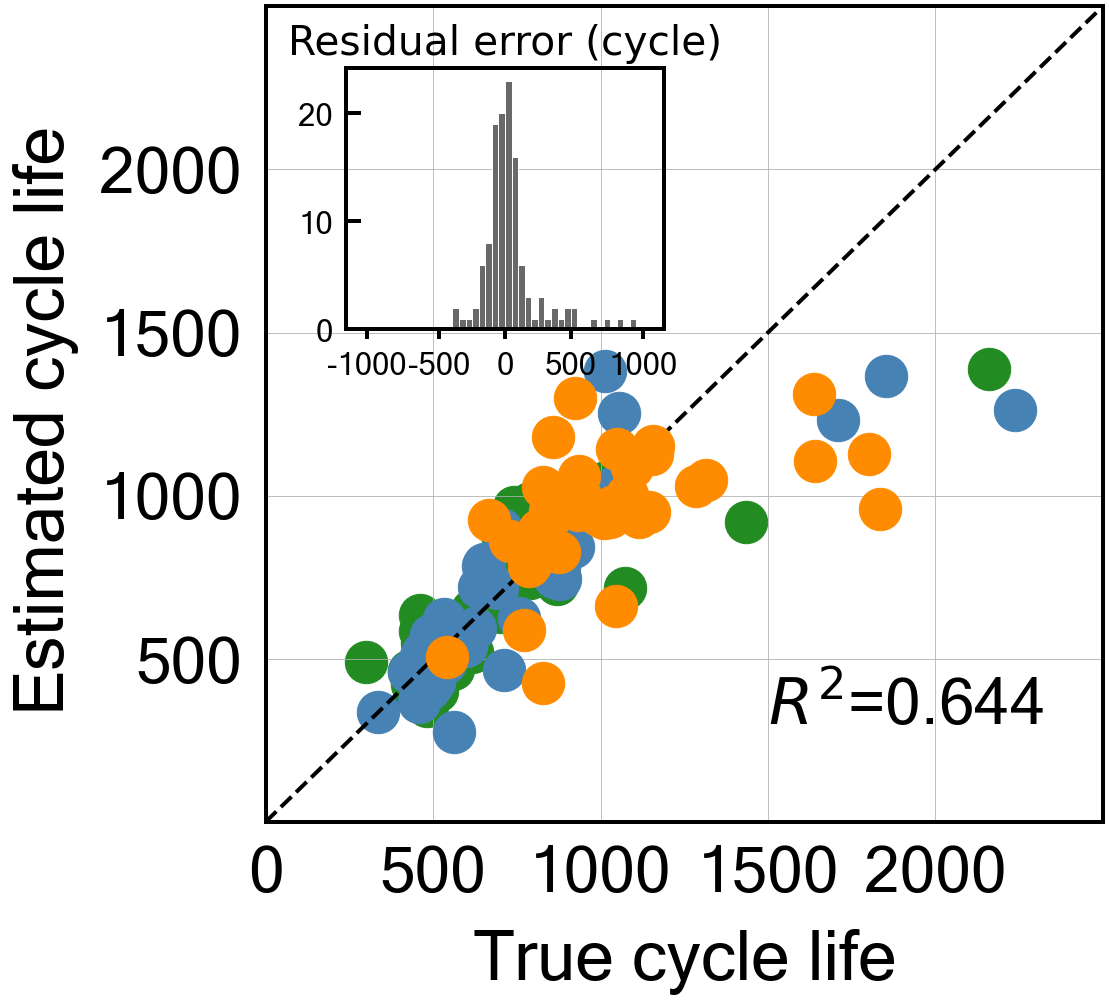

'\nNormal-scale scores\nAll data score: 0.644\nTrain data score: 0.691\nTest data score: 0.687\nSecondary test data score: 0.187'

In [12]:
#### Train the models now:
# Initiate savepath variable
savepath = os.path.join('.', 'filename.png')
natureIdx = feat_df[feat_df['dictionary'] == 'nature_dict'].index[0]
modelName = "Temperature"

combo = np.array([5, 6, 7, 15, 16, 18])
    
X_array = np.vstack(feat_df.loc[:, 'valueArray']).transpose()

print("\nTemperature model\nrScore compared --> 2nd dataset")

startTime = time.time()

r2ScoreBest = -10
featureKeynameListBest = []
saveFilePath = os.path.join(savepath, 'feat'+str(len(combo))+'update.png')
    
featureKeynameList = []
X_all = X_array[:, combo]

for j in combo:
    featureKeynameList.append(feat_df.loc[j, 'dictionary'] + str(feat_df.loc[j, 'keyName']))

X_train  = X_all[train_ind]
X_test = X_all[test_ind]
X_secondary_test = X_all[secondary_test_ind]

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_secondary_test_scaled = scaler.transform(X_secondary_test)
X_all_scaled = np.concatenate((X_train_scaled, X_test_scaled, X_secondary_test_scaled))

# Train
regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=20, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random')
model = regEN
model.fit(X_train_scaled, y_train)

#Evaluate score: SECONDARY DATASET
r2Score = r2_score(10**y_secondary_test, 10**model.predict(X_secondary_test_scaled))

if r2Score > r2ScoreBest:
    r2ScoreBest = r2Score
    featureKeynameListBest = featureKeynameList
    modelBest = model
    X_all_scaled_best = X_all_scaled
            
print("{} features combination".format(len(combo)))
print("\n------------------------------------------------------------------------\n")
print("Time elapsed: {:.1f}".format(time.time() - startTime))
print("Best score obtained was: ", r2ScoreBest)
print("with features: ", featureKeynameListBest)
train_utils.print_result(setCycleNo, modelBest, X_all_scaled_best, y_all, featureKeynameListBest, idlst=lenList)
plot_utils.build_all_comparison_graph_v2(X_all_scaled_best, y_all, modelBest, len_list = [len(train_ind), len(test_ind), len(secondary_test_ind)],  name=modelName)#, save = saveFilePath)

## Optional: Below is the exhaustive search to go through all possible combinations of feature subset: featAllIndexList
The best secondary test set accuracy is recorded for each n=1,2,.. len(featAllIndexList), where n is the number of combinations.

In [13]:
featTempBothIndexList = [0, 5, 6, 7, 13, 14, 15, 16, 17, 18, 20, 21, 22, 27]

In [14]:
# #### Uncomment below to run the exhaustive search
# # Initiate savepath
# savepath = os.path.join('.', 'filename')
# natureIdx = feat_df[feat_df['dictionary'] == 'nature_dict'].index[0]
# modelName = "Temperature [Ch + Dis]"

# columnIdx = featTempBothIndexList
    
# X_array = np.vstack(feat_df.loc[:, 'valueArray']).transpose()

# print("\nTemperature: Charge + Discharge\nrScore compared --> 2nd dataset")

# startTime = time.time()
# for i in range(1,len(columnIdx)+1):
#     secScoreBest = -100
#     priScoreBest = -100
#     multiplierConstant = 0
#     featureKeynameListBest = []
#     saveFilePath = os.path.join(savepath, 'feat'+str(i)+'.png')
    
#     for combo in itertools.combinations(columnIdx, i):
#         featureKeynameList = []
#         X_all = X_array[:, combo]

#         for j in combo:
#             featureKeynameList.append(feat_df.loc[j, 'dictionary'] + str(feat_df.loc[j, 'keyName']))

#         X_train  = X_all[train_ind]
#         X_test = X_all[test_ind]
#         X_secondary_test = X_all[secondary_test_ind]

#         scaler = StandardScaler().fit(X_train)
#         X_train_scaled = scaler.transform(X_train)
#         X_test_scaled = scaler.transform(X_test)
#         X_secondary_test_scaled = scaler.transform(X_secondary_test)
#         X_all_scaled = np.concatenate((X_train_scaled, X_test_scaled, X_secondary_test_scaled))

#         # Train
#         regEN = ElasticNetCV(l1_ratio=np.linspace(0.01,1,100), cv=4, random_state=20, max_iter=100000, n_jobs=3, tol=1e-2, verbose=0, selection='random')
#         model = regEN
#         model.fit(X_train_scaled, y_train)

#         y_all_pred = model.predict(X_all_scaled)
#         y_train_pred = model.predict(X_train_scaled)
#         y_primary_test_pred = model.predict(X_test_scaled)
#         y_secondary_test_pred = model.predict(X_secondary_test_scaled)

#         #Evaluate score: ALL DATASET using r2-score
#         allScore = r2_score(y_true = 10**y_all, y_pred = 10**y_all_pred)
#         trainScore = r2_score(y_true = 10**y_train, y_pred = 10**y_train_pred)
#         priTestScore = r2_score(y_true = 10**y_test, y_pred = 10**y_primary_test_pred)
#         secTestScore = r2_score(y_true = 10**y_secondary_test, y_pred = 10**y_secondary_test_pred)
        
#         if secTestScore > secScoreBest:
#             if (priTestScore - priScoreBest) > (-1.5 * (secTestScore - secScoreBest)):
#                 print("Accepted (secondary): ", featureKeynameList, "\nAll: {:.3f}, Train: {:.3f}, Primary test: {:.3f}, Secondary test: {:.3f}".format(allScore, trainScore, priTestScore, secTestScore))
#                 featureKeynameListBest = featureKeynameList
#                 modelBest = model
#                 X_all_scaled_best = X_all_scaled
#                 secScoreBest = secTestScore
#                 priScoreBest = priTestScore
#             else: 
#                 print("Rejected: ", featureKeynameList, "\nAll: {:.3f}, Train: {:.3f}, Primary test: {:.3f}, Secondary test: {:.3f}".format(allScore, trainScore, priTestScore, secTestScore))
                
#         elif (secScoreBest - secTestScore) < 0.075:
#             if (secScoreBest - secTestScore) < 0.025: multiplierConstant = -4
#             else: multiplierConstant = -2
            
#             if (priTestScore - priScoreBest) > (multiplierConstant * (secTestScore - secScoreBest)):
#                 print("Accepted (primary): ", featureKeynameList, "\nAll: {:.3f}, Train: {:.3f}, Primary test: {:.3f}, Secondary test: {:.3f}".format(allScore, trainScore, priTestScore, secTestScore))
#                 featureKeynameListBest = featureKeynameList
#                 modelBest = model
#                 X_all_scaled_best = X_all_scaled
#                 secScoreBest = secTestScore
#                 priScoreBest = priTestScore
#             else:
#                 print("Skipped: ", featureKeynameList, "\nAll: {:.3f}, Train: {:.3f}, Primary test: {:.3f}, Secondary test: {:.3f}".format(allScore, trainScore, priTestScore, secTestScore))

#         else: continue
            
#     print("{} features combination".format(i))
#     print("\n------------------------------------------------------------------------\n")
#     print("Time elapsed: {:.1f}".format(time.time() - startTime))
#     print("Best score obtained was: ", secScoreBest)
#     print("with features: ", featureKeynameListBest)
#     train_utils.print_result(setCycleNo, modelBest, X_all_scaled_best, y_all, featureKeynameListBest, idlst=lenList)
#     plot_utils.build_all_comparison_graph_v2(X_all_scaled_best, y_all, modelBest, len_list = [len(train_ind), len(test_ind), len(secondary_test_ind)],  name=modelName)#, save = saveFilePath)